In [1]:
import gc
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

%matplotlib inline

Using TensorFlow backend.
C:\Users\My PC\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\My PC\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\My PC\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\My PC\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Load Dataset

In [2]:
df = pd.read_csv('price_market.csv')   
df.set_index(pd.DatetimeIndex(df['Date']), inplace=True)
target = df['BTC_Price']
df = df.drop(['Date', 'BTC_Price'], axis=1)
print('Size of dataset: ', df.shape[0], 'x', df.shape[1])
df.head(5)

Size of dataset:  1583 x 15


,DOW_Price,NASDAQ_Price,GOLD_Price,USD_Price,US_BCI,US_CCI,US2TB,US30TB,ETH,XRP,US_INTR,S&P,BTCCash,LTC,Gsearch
Date,,,,,,,,,,,,,,,
2012-02-02,12705.41,2859.68,1756.8,79.11,100.07,98.71,110.37,144.59,0.0,0.0,0.75,1325.54,0.0,0.0,1
2012-02-03,12862.23,2905.66,1737.9,79.06,100.07,98.71,110.33,142.41,0.0,0.0,0.75,1344.90,0.0,0.0,1
2012-02-06,12845.13,2901.99,1722.8,79.19,100.07,98.71,110.35,143.28,0.0,0.0,0.75,1344.33,0.0,0.0,1
2012-02-07,12878.20,2904.08,1746.4,78.67,100.07,98.71,110.31,142.31,0.0,0.0,0.75,1347.05,0.0,0.0,1
2012-02-08,12883.95,2915.86,1729.3,78.73,100.07,98.71,110.30,142.22,0.0,0.0,0.75,1349.96,0.0,0.0,1


<i>Features</i>:<br>
Stocks : <b>Dow Jones Industrial Index, NASDAQ, S&P 500</b> <br>
Forex : <b>Gold (comex) Index, USD basket Index</b> <br>
OECD Economic Statistics : <b>US Business Confidence Index, US Consumer Confidence Index</b> <br>
Bonds : <b>US-2-year treasury bond futures, US-30-year treasury bond futures</b> <br>
Other Crypto-currencies : <b>Ethereum, Ripple, BTCCash, Litecoin</b> <br>
And Google Trends : <b>precentiles of "Bitcoin" searches on Google (1 : bottom 1%, 100 : top 100% percent of searches)</b> <br>

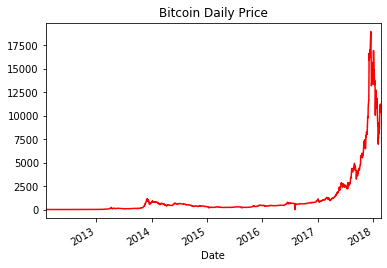

In [3]:
target.plot(title='Bitcoin Daily Price', style='r')

## <b>DATA EXPLORATION AND VISUALIZATION</b><br>

The volume and number of features of our dataset is too large. So we decided to do as following:<br>
1. Slice the time series<br>
2. Perform PCA on market data & trend data for variable selection<br>

Only significant parts of our data explorations are shown:<br><br>

1) Period of interest<br>

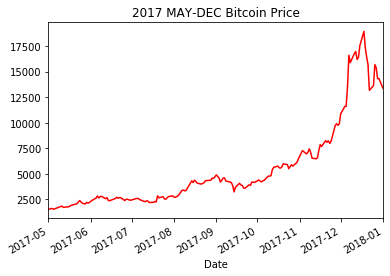

In [4]:
price_2017 = target['20170501':'20180101']
price_2017.plot(title='2017 MAY-DEC Bitcoin Price', style='r')

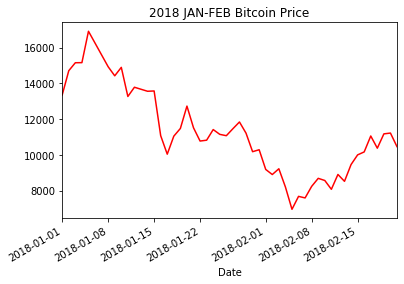

In [5]:
price_2018 = target['20180101':'20180301']
price_2018.plot(title='2018 JAN-FEB Bitcoin Price', style='r')

<br>
2) Correlation analysis on features

In [6]:
def color_high_val(val):
    color = "red" if val > 0.9 else 'black' 
    return 'color: %s' % color
corr_output = df.corr(method = 'pearson', min_periods = 1)
corr_output.style.applymap(color_high_val)

,DOW_Price,NASDAQ_Price,GOLD_Price,USD_Price,US_BCI,US_CCI,US2TB,US30TB,ETH,XRP,US_INTR,S&P,BTCCash,LTC,Gsearch
DOW_Price,1,0.984278,-0.56308,0.630469,0.624906,0.845362,-0.935729,0.315295,0.720688,0.609181,0.822728,0.983644,0.624257,0.675269,0.715972
NASDAQ_Price,0.984278,1,-0.629307,0.716821,0.542192,0.888361,-0.92338,0.400193,0.647413,0.540684,0.81395,0.993182,0.547246,0.601861,0.643577
GOLD_Price,-0.56308,-0.629307,1,-0.670698,-0.155182,-0.703301,0.404502,-0.195503,-0.0484824,-0.0368669,-0.2875,-0.667519,-0.0315272,-0.0511264,-0.123163
USD_Price,0.630469,0.716821,-0.670698,1,-0.0465423,0.887659,-0.628473,0.726016,0.136666,0.105012,0.62835,0.708305,0.087016,0.128213,0.159943
US_BCI,0.624906,0.542192,-0.155182,-0.0465423,1,0.291491,-0.528606,-0.35169,0.552356,0.444435,0.480552,0.553728,0.488355,0.522141,0.568572
US_CCI,0.845362,0.888361,-0.703301,0.887659,0.291491,1,-0.780472,0.557679,0.37216,0.293508,0.715796,0.893307,0.302826,0.346225,0.38753
US2TB,-0.935729,-0.92338,0.404502,-0.628473,-0.528606,-0.780472,1,-0.370174,-0.778419,-0.665131,-0.899906,-0.89382,-0.671964,-0.729173,-0.742999
US30TB,0.315295,0.400193,-0.195503,0.726016,-0.35169,0.557679,-0.370174,1,0.0799638,0.0549962,0.451751,0.378294,0.056275,0.071239,0.0647519
ETH,0.720688,0.647413,-0.0484824,0.136666,0.552356,0.37216,-0.778419,0.0799638,1,0.919539,0.585904,0.615691,0.90251,0.9334,0.865962
XRP,0.609181,0.540684,-0.0368669,0.105012,0.444435,0.293508,-0.665131,0.0549962,0.919539,1,0.469963,0.516716,0.875696,0.883299,0.764306


Strong correlation pairs:<br>
<b>(DOW_Price,NASDAQ_Price), (DOW_Price, S&P), (NASDAQ_Price, S&P), (ETH, XRP), (ETH, BTCCash), (ETH, LTC), (BTCCash, LTC), (BTCCash, Gsearch), (LTC, Gsearch)</b><br><br>

In [7]:
df_use = df['20170501':'20180301']
target_use = target['20170501':'20180301']
target_use = pd.DataFrame(data=target_use.values, columns=['BTC_Price'])   # get rid of date index

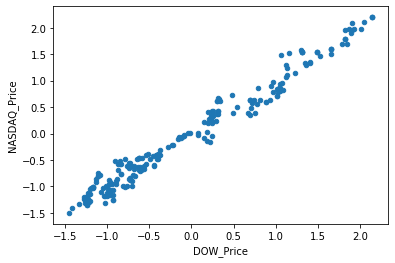

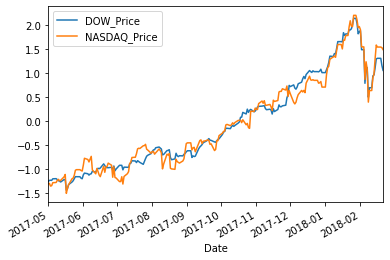

In [8]:
pair = df_use.loc[:, lambda df_use: ['DOW_Price', 'NASDAQ_Price']]
pair = (pair-pair.mean())/pair.std()   # Normalize
pair.plot.scatter(x='DOW_Price', y='NASDAQ_Price')
pair.plot()

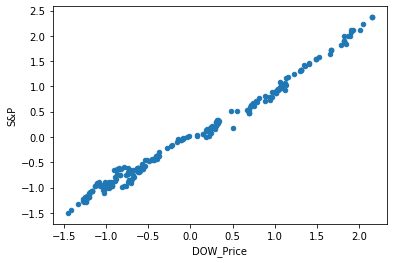

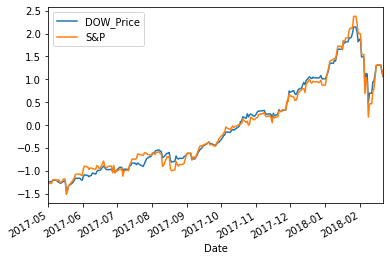

In [9]:
pair = df_use.loc[:, lambda df_use: ['DOW_Price', 'S&P']]
pair = (pair-pair.mean())/pair.std()   # Normalize
pair.plot.scatter(x='DOW_Price', y='S&P')
pair.plot()

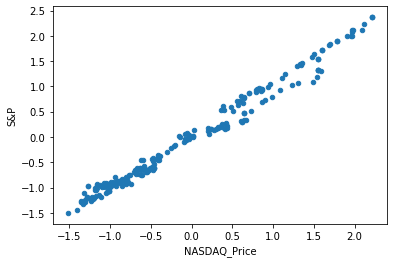

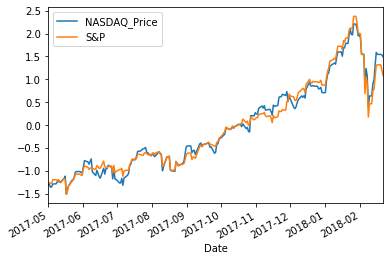

In [10]:
pair = df_use.loc[:, lambda df_use: ['NASDAQ_Price', 'S&P']]
pair = (pair-pair.mean())/pair.std()   # Normalize
pair.plot.scatter(x='NASDAQ_Price', y='S&P')
pair.plot()

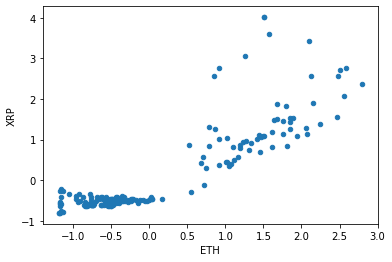

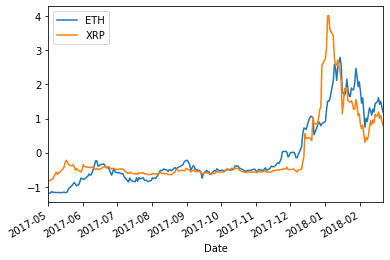

In [11]:
pair = df_use.loc[:, lambda df_use: ['ETH', 'XRP']]
pair = (pair-pair.mean())/pair.std()   # Normalize
pair.plot.scatter(x='ETH', y='XRP')
pair.plot()

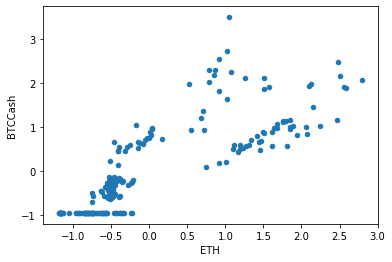

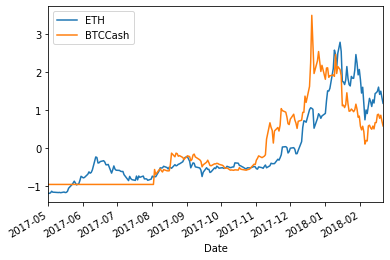

In [12]:
pair = df_use.loc[:, lambda df_use: ['ETH', 'BTCCash']]
pair = (pair-pair.mean())/pair.std()   # Normalize
pair.plot.scatter(x='ETH', y='BTCCash')
pair.plot()

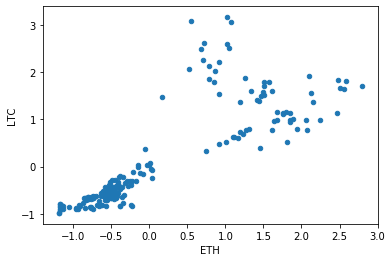

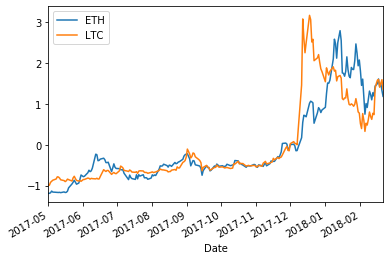

In [13]:
pair = df_use.loc[:, lambda df_use: ['ETH', 'LTC']]
pair = (pair-pair.mean())/pair.std()   # Normalize
pair.plot.scatter(x='ETH', y='LTC')
pair.plot()

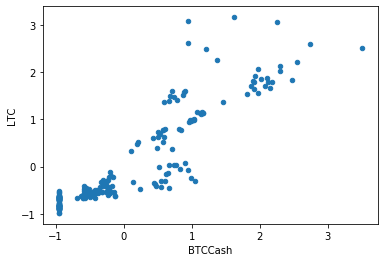

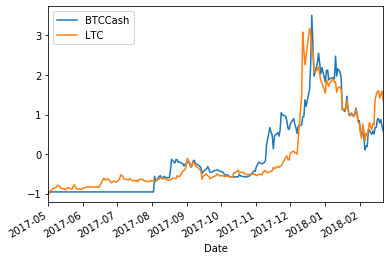

In [14]:
pair = df_use.loc[:, lambda df_use: ['BTCCash', 'LTC']]
pair = (pair-pair.mean())/pair.std()   # Normalize
pair.plot.scatter(x='BTCCash', y='LTC')
pair.plot()

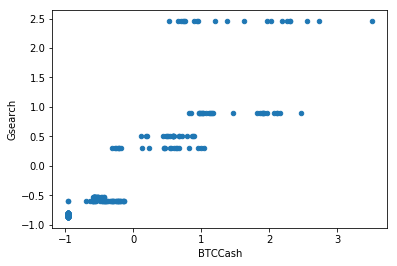

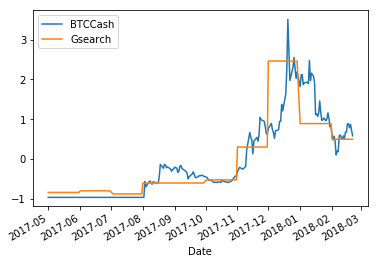

In [15]:
pair = df_use.loc[:, lambda df_use: ['BTCCash', 'Gsearch']]
pair = (pair-pair.mean())/pair.std()   # Normalize
pair.plot.scatter(x='BTCCash', y='Gsearch')
pair.plot()

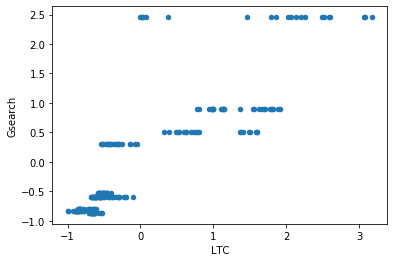

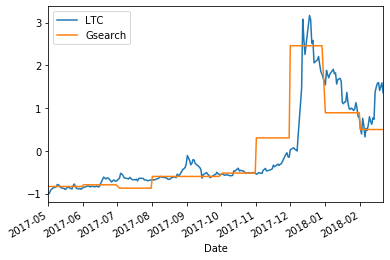

In [15]:
pair = df_use.loc[:, lambda df_use: ['LTC', 'Gsearch']]
pair = (pair-pair.mean())/pair.std()   # Normalize
pair.plot.scatter(x='LTC', y='Gsearch')
pair.plot()

Based on domain knowledge, we decided candidates for <b>PCA</b>(Principle Component Analysis):<br>
<b>DOW_Price, NASDAQ_Price, S&P, BTCCash, LTC</b>

<br>
## <b>PREPROCESS OF DATA</b>
<br>
<b>1) PCA PROJECTION TO 2-D</b>

In [16]:
pca_features = ['DOW_Price', 'NASDAQ_Price', 'S&P', 'BTCCash', 'LTC']
temp = df_use.loc[:, lambda df_use: pca_features].values
temp = StandardScaler().fit_transform(temp)             # Normalize

pca = PCA(n_components=2)
principal_components = pca.fit_transform(temp)          # PCA Projection
principalDf = pd.DataFrame(data=principal_components, columns=['pc1', 'pc2'])
principalDf.head()

,pc1,pc2
0,-2.606116,0.261020
1,-2.583144,0.241431
2,-2.587472,0.313998
3,-2.570140,0.324893
4,-2.480942,0.280163


<br>
<b>2) NORMALIZE THE REST DATA</b>

In [17]:
other_features = ['GOLD_Price','USD_Price','US_BCI','US_CCI','US2TB','US30TB','ETH','XRP','US_INTR','Gsearch']
df_use = df_use.drop(pca_features, axis=1).values
df_use = StandardScaler().fit_transform(df_use)            # Normalize
df_use = pd.DataFrame(data=df_use, columns=other_features)
df_use.head()

,GOLD_Price,USD_Price,US_BCI,US_CCI,US2TB,US30TB,ETH,XRP,US_INTR,Gsearch
0,-0.870003,2.065725,-2.023231,0.047632,0.938386,-0.192119,-1.194125,-0.824048,0.0,-0.833332
1,-0.829288,2.027541,-2.023231,0.047632,1.019947,0.028910,-1.192204,-0.824048,0.0,-0.833332
2,-1.060005,2.123002,-2.023231,0.047632,0.922074,0.046592,-1.180296,-0.805845,0.0,-0.833332
3,-1.600155,1.958808,-2.023231,0.047632,0.856825,-0.274637,-1.138055,-0.787642,0.0,-0.833332
4,-1.646299,1.912986,-2.023231,0.047632,0.840513,-0.248113,-1.162310,-0.769439,0.0,-0.833332


<br>
<b>3) CONCATENATE</b>

In [18]:
finalDf = pd.concat([principalDf, df_use], axis=1)
finalDf.head()

,pc1,pc2,GOLD_Price,USD_Price,US_BCI,US_CCI,US2TB,US30TB,ETH,XRP,US_INTR,Gsearch
0,-2.606116,0.261020,-0.870003,2.065725,-2.023231,0.047632,0.938386,-0.192119,-1.194125,-0.824048,0.0,-0.833332
1,-2.583144,0.241431,-0.829288,2.027541,-2.023231,0.047632,1.019947,0.028910,-1.192204,-0.824048,0.0,-0.833332
2,-2.587472,0.313998,-1.060005,2.123002,-2.023231,0.047632,0.922074,0.046592,-1.180296,-0.805845,0.0,-0.833332
3,-2.570140,0.324893,-1.600155,1.958808,-2.023231,0.047632,0.856825,-0.274637,-1.138055,-0.787642,0.0,-0.833332
4,-2.480942,0.280163,-1.646299,1.912986,-2.023231,0.047632,0.840513,-0.248113,-1.162310,-0.769439,0.0,-0.833332


<br>
## <b>SPLIT THE DATA</b>
<br>
TRAIN : TEST = 4 : 1

In [19]:
train_x, test_x, train_y, test_y = train_test_split(finalDf, target_use, test_size=1/5.0, random_state=0, shuffle=True)

print('Size of TRAIN DATA:', train_x.shape[0], 'x', train_x.shape[1])
print('Size of TRAIN LABEL:', train_y.shape[0], 'x', train_y.shape[1])
print('Size of TEST DATA:', test_x.shape[0], 'x', test_x.shape[1])
print('Size of TEST LABEL:', test_y.shape[0], 'x', test_y.shape[1])

Size of TRAIN DATA: 180 x 12
Size of TRAIN LABEL: 180 x 1
Size of TEST DATA: 46 x 12
Size of TEST LABEL: 46 x 1


<br>
## <b>MODEL TRAINING</b>
<br>
<b>Model 1:</b> Linear Regression

In [20]:
linear_r = LinearRegression()
linear_r.fit(train_x, train_y)
print()

<br>
<b>Model 2:</b> Logistic Regression

In [21]:
logistic_r = LogisticRegression()
train_label_LoR = np.array(train_y).ravel()
enc = preprocessing.LabelEncoder()
train_label_LoR = enc.fit_transform(train_label_LoR)
logistic_r.fit(train_x, train_label_LoR)
print()

C:\Users\My PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\My PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


<br>
<b>Model 3:</b> Support Vector Machine

In [22]:
svr = SVR(kernel='linear', epsilon=0.1, C=10)
svr.fit(train_x, train_y)
print()

C:\Users\My PC\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<br>
<b>Model 4:</b> K Nearest Neighbor

In [23]:
knn_regression = KNeighborsRegressor(n_neighbors=5)
knn_regression.fit(train_x, train_y)
print()

<br>
<b>Model 5:</b> Recurrent Neural Network (LSTM)
<br>
<br>
- Utility Functions

In [24]:
def create_input(data, window_size=7):
    '''
    Creates input array from the given dataset
    
    - data: pandas DataFrame instance
    - window_size: look back window size. 7 by default
    
    Returns: python list
    '''
    inputs=[]
    for i in range(len(data)-window_size):
        temp = data[ i : (i+window_size) ].copy()
        inputs.append(temp)
    return inputs

def create_output(data, window_size=7):
    '''
    Creates output array from the given dataset and normalize the data
    
    - data: pandas DataFrame instance
    - window_size: look back window size. 7 by default
    
    Returns: numpy array instance for normalized bitcoin price
    '''
    return (data['BTC_Price'][window_size:].values / data['BTC_Price'][:-window_size].values) - 1

def to_nparray(data):
    '''
    Converts list of inputs into a numpy array
    
    - data: pandas DataFrame
    
    Returns: numpy array
    '''
    x = [np.array(data[i]) for i in range(len(data))]
    return np.array(x)

def build_model(inputs, output_size, num_neurons, activation_func='relu', dropout=0.25, loss='mse', optimizer='adam'):
    '''
    This function builds 3 layered RNN model with LSTM(Long Short-Term Memory) layers and Dense Layer
    
    - inputs: numpy array for input data
    - output_size: number of predictions per input sample
    - num_neurons: number of neurons / units in the LSTM layer
    - activation_func: activation function to be used in LSTM layers & Dense layer
    - dropout: dropout ratio. 0.25 by default
    - loss: loss function for calculating the gradient
    - optimizer: type of optimizer to backpropagate the gradient
    
    Returns: Keras sequential model and model summary
    '''
    model = Sequential()
    model.add(LSTM(num_neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activation_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activation_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation=activation_func))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activation_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    model.summary()
    return model

def plot_results(history, model, x_train, y_train, x_target, y_target):
    plt.figure(figsize=(25, 20))
    plt.subplot(311)
    plt.plot(history.epoch, history.history['loss'], )
    plt.plot(history.epoch, history.history['val_loss'])
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend(['Training', 'Test'])

    plt.subplot(312)
    plt.plot(y_train)
    plt.plot(model.predict(x_train))
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.title('Single Point Price Prediction on Training Set')
    plt.legend(['Actual','Predicted'])
    
    plt.subplot(313)
    plt.plot(y_test)
    plt.plot(model.predict(x_test))
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.title('Single Point Price Prediction on Test Set')
    plt.legend(['Actual','Predicted'])

    plt.show()

<br>
- Dataset for LSTM aided RNN

In [25]:
x_train = create_input(train_x)
y_train = create_output(train_y)
x_test = create_input(test_x)
y_test = create_output(test_y)

x_train, x_test = to_nparray(x_train), to_nparray(x_test)

<br>
- Model Instantiation

In [26]:
# hyperparameters
neurons = 512                 
loss = 'mse'                  
batch_size = 12               
epochs = 30

gc.collect()         # clean up the memory
np.random.seed(202)  #random seed for reproducibility
rnn = build_model(x_train, output_size=1, num_neurons=neurons)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 512)            1075200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_3 (Dropout)  

<br>
- Train

In [27]:
history = rnn.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test), shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 173 samples, validate on 39 samples
Epoch 1/30
173/173 [==============================] - 9s 52ms/step - loss: 2.9509 - mean_absolute_error: 1.2016 - val_loss: 1.7141 - val_mean_absolute_error: 0.9800
Epoch 2/30
173/173 [==============================] - 5s 27ms/step - loss: 3.2746 - mean_absolute_error: 1.2457 - val_loss: 2.1727 - val_mean_absolute_error: 0.9505
Epoch 3/30
173/173 [==============================] - 5s 27ms/step - loss: 2.7284 - mean_absolute_error: 1.0939 - val_loss: 1.5233 - val_mean_absolute_error: 0.9387
Epoch 4/30
173/173 [==============================] - 5s 27ms/step - loss: 2.2296 - mean_absolute_error: 1.1342 - val_loss: 2.0027 - val_mean_absolute_error: 1.1654
Epoch 5/30
173/173 [==============================] - 5s 27ms/step - loss: 2.4272 - mean_absolute_error: 1.1429 - val_loss: 1.4606 - val_mean_absolute_error: 0.8684
Epoch 6/30
173/173 [==============================] - 5s 29ms/step - loss: 1.8248 

<br>
## <b>VALIDATION</b>

<br>
<b>Model 1:</b> Linear Regression

In [29]:
print('linear r^2 score : {:.4f}'.format(linear_r.score(test_x, test_y)))
print('linear rmse score : {:.4f}'.format(metrics.mean_squared_error(test_y, linear_r.predict(test_x))))

linear r^2 score : 0.9609
linear rmse score : 850274.7731


<br>
<b>Model 2:</b> Logistic Regression

In [30]:
test_label_LoR = np.array(test_y).ravel()
enc = preprocessing.LabelEncoder()
test_label_LoR = enc.fit_transform(test_label_LoR)

print('logistic r^2 score : {:.4f}'.format(logistic_r.score(test_x, test_label_LoR)))
print('logistic rmse score : {:.4f}'.format(metrics.mean_squared_error(test_label_LoR, logistic_r.predict(test_x))))

logistic r^2 score : 0.0000
logistic rmse score : 7412.2826


<br>
<b>Model 3:</b> Support Vector Machine

In [31]:
print('svr r^2 score : {:.4f}'.format(svr.score(test_x, test_y)))
print('svr rmse score : {:.4f}'.format(metrics.mean_squared_error(test_y, svr.predict(test_x))))

svr r^2 score : 0.8643
svr rmse score : 2950590.8744


<br>
<b>Model 4:</b> K Nearest Neighbor

In [32]:
print('knn r^2 score : {:.4f}'.format(knn_regression.score(test_x, test_y)))
print('knn rmse score : {:.4f}'.format(metrics.mean_squared_error(test_y, knn_regression.predict(test_x))))

knn r^2 score : 0.9756
knn rmse score : 530491.4461


<br>
<b>Model 5:</b> Recurrent Neural Network

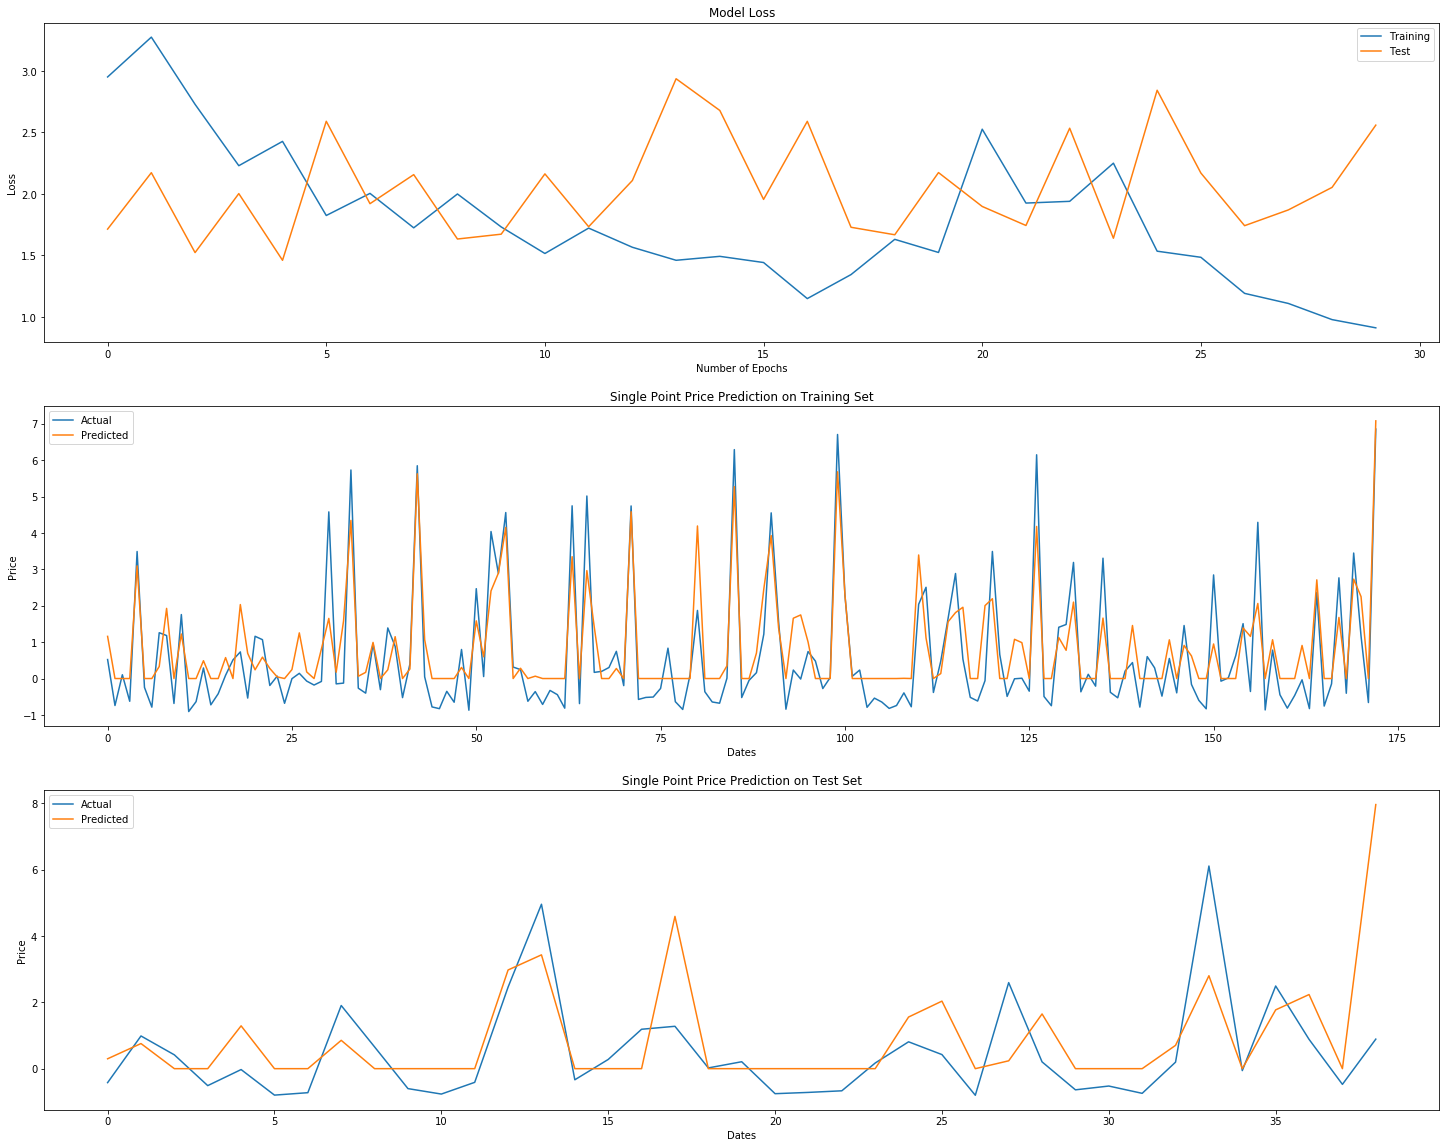

mean_absolute_error: 1.03%


In [33]:
plot_results(history, rnn, x_train, y_train, x_test, y_test)
scores = rnn.evaluate(x_test, y_test, verbose=0)
print('%s: %.2f%%' % (rnn.metrics_names[1], scores[1]))

<br>
## <b>POSSIBLE IMPROVEMENTS</b>
<br>
<b>1. PCA step:</b> I conducted PCA just for the primisive 5 features which have strong correlations. But I can simply conduct PCA for the whole columns, with PCA parameter <b>n_components</b> = 12.
<br>
<b>2. Data ablation study:</b> we can obtain better refined dataset by trying all the combinations of data.
<br>
<b>3. RNN model:</b> As you can see in the summary above, the RNN model used here has 3 LSTM layers. This is not the optimal model which still can be improved.